In [218]:
import pickle
import gc

import torch
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'

gc.collect()
torch.cuda.empty_cache()

In [219]:
def process_error_data(fname, T):

    with open(fname, "rb") as fp:
        info = pickle.load(fp)
    
    # Collect the training times of each model
    model_times = []
    for t in range(len(info[0])):  # info[seed]
        t_i = info[0][t][0]  # info[seed][time_model][0]
        model_times.append(t_i)
    
    # Number of seeds (assuming each model has the same number of seeds)
    num_seeds = len(info)
    
    seed_errs = []
    times = []
    time_models = len(model_times)
    
    for t in range(time_models):
        t_i = model_times[t]
        if t < len(model_times) - 1:
            t_next = model_times[t + 1]
        else:
            t_next = T  # For the last model, extend to the total time T
        times_segment = list(range(t_i, t_next))
        times.extend(times_segment)
    
    # Process each seed to collect errors
    for seed in range(num_seeds):
        errs = []
        for t in range(time_models):
            t_i = model_times[t]
            if t < len(model_times) - 1:
                t_next = model_times[t + 1]
            else:
                t_next = T  # For the last model, extend to the total time T
    
            t_i_check, arr = info[seed][t]  # info[seed][time_model]
            assert t_i_check == t_i, f"Mismatch in training times: {t_i_check} != {t_i}"
    
            arr_segment = arr[t_i:t_next]
            errs.extend(arr_segment)
    
        seed_errs.append(errs)
    
    seed_errs = np.array(seed_errs)  # Shape: (num_seeds, total_time_length)
    
    mean = np.mean(seed_errs, axis=0)
    std = np.std(seed_errs, axis=0)
    
    return times, mean, std

def qplot_ins_err(errors,label_name = 'Prospective 3MLP',end_time=1750):
    # Plotting the errors over time
    plt.figure(figsize=(12, 6))

    start_time = 0

    plt.plot(np.arange(start_time,end_time,1), errors[start_time:end_time:1], label=label_name, color='black')

    colors = ['blue', 'yellow']
    current_color_index = 0

    for start in range(start_time, end_time, 20):
        end = min(start + 20, end_time)
        plt.axvspan(start, end, facecolor=colors[current_color_index % 2], alpha=0.3)
        current_color_index += 1

    plt.xlim(start_time,end_time)
    plt.xlabel('Time')
    plt.ylabel('Instaneous Risk')
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()

In [220]:
# This checkpoint was trained from Rahul's version.

# python3 02_train.py net.type=prospective_mlp name='mlp_prospective_basic' \
# tag=scenario2_m1 numseeds=5 ntest=100\
# tstart=20 tskip=100 tend=2021 dev='cuda:0'
T = 2000
fname = "./checkpoints/scenario2_m1/mlp_prospective_basic_errs.pkl"
pl_times, pl_inst_errors, pl_inst_std = process_error_data(fname, T)

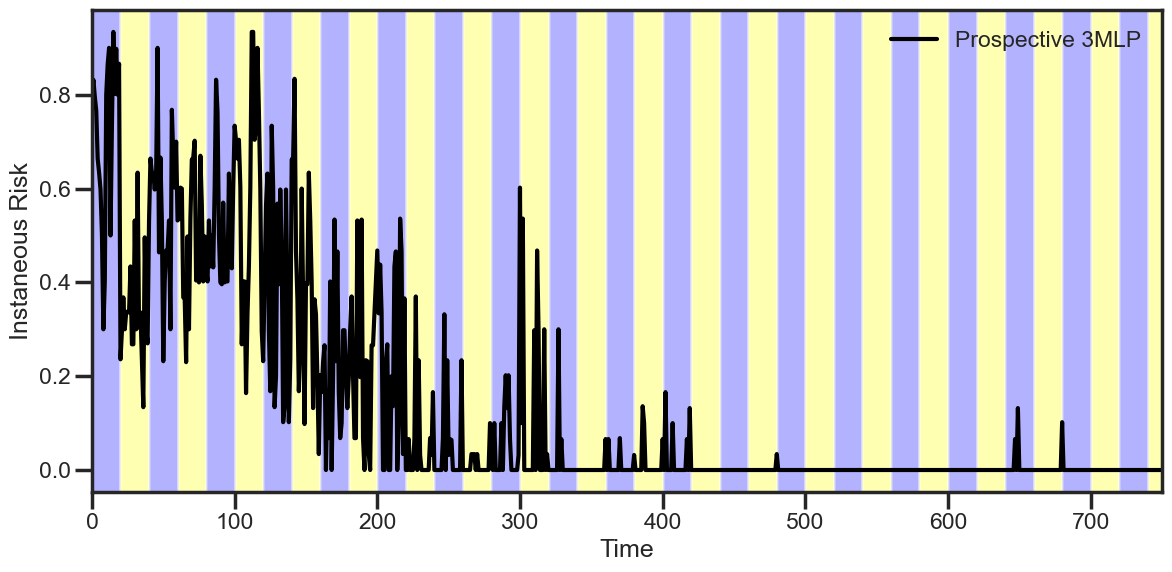

In [221]:
qplot_ins_err(pl_inst_errors,end_time=750)

In [222]:
def create_metrics(fnames, fout, model_names):

    infos = []
    for fname in fnames:
        with open(fname, "rb") as fp:
            info = pickle.load(fp)
        infos.append(info)

    plot_metrics = {}


    for model in range(len(infos)):

        seed_errs = []
        times = []

        for seed in range(len(infos[model])):
            info = infos[model][seed]

            errs = []
            for row in info:
                t, arr = row
                if seed == 0:
                    times.append(t)

                errs.append(np.mean(arr[t:]))
            seed_errs.append(errs)
        seed_errs = np.array(seed_errs)

        mean = np.mean(seed_errs, axis=0)
        std = np.std(seed_errs, axis=0)

        plot_metrics[model_names[model]] = np.array([mean, std, times])

    with open(fout, "wb") as fp:
        pickle.dump(plot_metrics, fp)
save_path = './checkpoints/scenario2_m1/'

model_names_s2 = [ "Prospective"]
fnames_syn_s2 = [save_path+"mlp_prospective_basic_errs.pkl"]
fout_syn_s2 = "./metrics/syn_scenario2_mlp3.pkl"
create_metrics(fnames_syn_s2,fout_syn_s2,model_names_s2)

info = np.load("./metrics/syn_scenario2_mlp3.pkl", allow_pickle=True)
pl_plrisk,pl_plrisk_std,pl_plrisk_times = info['Prospective']

In [223]:
def online_sample_from_task_sequence(t, N=20):
    # Determine which task we are in at time t
    task = (t // N) % 2 + 1

    # Sample X from the uniform distribution on the set [-2, -1] U [1, 2]
    X = np.random.choice([-1, 1]) * (1 + np.random.rand())

    # Determine label Y based on the current task
    if task == 1:
        Y = np.sign(X)
    else:
        Y = -np.sign(X)

    return X, Y

def batch_sample_for_future_points(n, t, T, N=20, seed=1996):
    np.random.seed(seed)
    X = []
    Y = []

    for future_t in range(t, T):
        task = (future_t // N) % 2 + 1
        x_batch = np.random.choice([-1, 1], size=n) * (1 + np.random.rand(n))

        if task == 1:
            y_batch = np.sign(x_batch)
        else:
            y_batch = -np.sign(x_batch)

        X.append(x_batch)
        Y.append(y_batch)

    return np.array(X), np.array(Y)

In [224]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from deep_nets.utils.net import MLP_3L

# Parameters
N = 20
T = 2000
n_test = 50
n_reps = 5
k = 100  # New parameter for prospective error interval

# Ensure device is set to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
save_path = './checkpoints/scenario2_m1/'


# Define OGD loop function using PyTorch and the new MLP model
def ogd_loop_torch():
    # Initialize the MLP model and optimizer
    model = MLP_3L(1,1,32).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    ogd_error = []
    prospective_errors = []

    for t in range(1, T + 1):
        # Obtain new sample from the online sampling function
        x, y = online_sample_from_task_sequence(t, N)
        x = torch.tensor([[x]], device=device, dtype=torch.float32)  # Adjusted shape for MLP
        y = torch.tensor([[y]], device=device, dtype=torch.float32)

        # Obtain test samples for evaluation at time t
        X_test, Y_test = batch_sample_for_future_points(n_test, t, t + 1, N)
        X_test = torch.tensor(X_test[0], device=device, dtype=torch.float32).view(-1, 1)
        Y_test = torch.tensor(Y_test[0], device=device, dtype=torch.float32).view(-1, 1)

        # Make predictions and calculate current error
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            Y_hat = torch.sign(model(X_test))
        ogd_error.append((Y_test != Y_hat).float().mean().item())

        # Calculate prospective errors every k steps
        if t % k == 0:
            # Obtain test samples for future evaluation from t to T
            X_future, Y_future = batch_sample_for_future_points(n_test, t, T, N)
            future_errors = []

            for future_idx in range(len(X_future)):
                X_future_test = torch.tensor(X_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)
                Y_future_test = torch.tensor(Y_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)

                # Make predictions for future points and calculate error
                with torch.no_grad():
                    Y_hat_future = torch.sign(model(X_future_test))
                future_errors.append((Y_future_test != Y_hat_future).float().mean().item())

            # Calculate the mean prospective error for the current time step
            prospective_errors.append(np.mean(future_errors))

        # Online gradient descent update
        model.train()  # Set model to training mode
        optimizer.zero_grad()
        loss = torch.nn.BCEWithLogitsLoss()(model(x), (y + 1) / 2)  # Use BCE with target in range [0,1]
        loss.backward()
        optimizer.step()

    return ogd_error, prospective_errors

file_path = save_path + 'ogd.pkl'
# Check if the file already exists
if not os.path.exists(file_path):
    # Running multiple repetitions and managing GPU memory
    ogd_error_reps = []
    prospective_error_reps = []

    for _ in range(n_reps):
        ogd_error, prospective_errors = ogd_loop_torch()

        # Move results to CPU to free GPU memory
        ogd_error_reps.append(torch.tensor(ogd_error).cpu())
        prospective_error_reps.append(torch.tensor(prospective_errors).cpu())

        # Clear GPU memory after each repetition
        torch.cuda.empty_cache()

    # Convert lists to tensors
    ogd_error_reps = torch.stack(ogd_error_reps)
    prospective_error_reps = torch.stack(prospective_error_reps)

    # Calculate mean and confidence intervals
    ogd_error = ogd_error_reps.mean(dim=0).numpy()
    ogd_prospective_error = prospective_error_reps.mean(dim=0).numpy()
    c_ogd = ogd_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96
    c_ogd_prospective = prospective_error_reps.std(dim=0).numpy() / (n_reps ** 0.5)

    # Save results to a pickle file
    with open(file_path, 'wb') as f:
        pickle.dump({
            'ogd_error': ogd_error,
            'ogd_prospective_error': ogd_prospective_error,
            'c_ogd': c_ogd,
            'c_ogd_prospective': c_ogd_prospective
        }, f)

# Code to read the saved pickle file
with open(file_path, 'rb') as f:
    results = pickle.load(f)

# Access the saved data
ogd_error = results['ogd_error']
ogd_prospective_error = results['ogd_prospective_error']
c_ogd = results['c_ogd']
c_ogd_prospective = results['c_ogd_prospective']

print("OGD Error:", ogd_error)
print("Prospective Error:", ogd_prospective_error)

OGD Error: [0.5   0.2   0.204 ... 0.5   0.5   0.5  ]
Prospective Error: [0.5018042  0.50049999 0.50183528 0.50074999 0.50171999 0.50062571
 0.5042923  0.50057665 0.50110908 0.5        0.50854221 0.49993
 0.50091427 0.5        0.50488799 0.50014999 0.53333333 0.51119999
 0.6               nan]


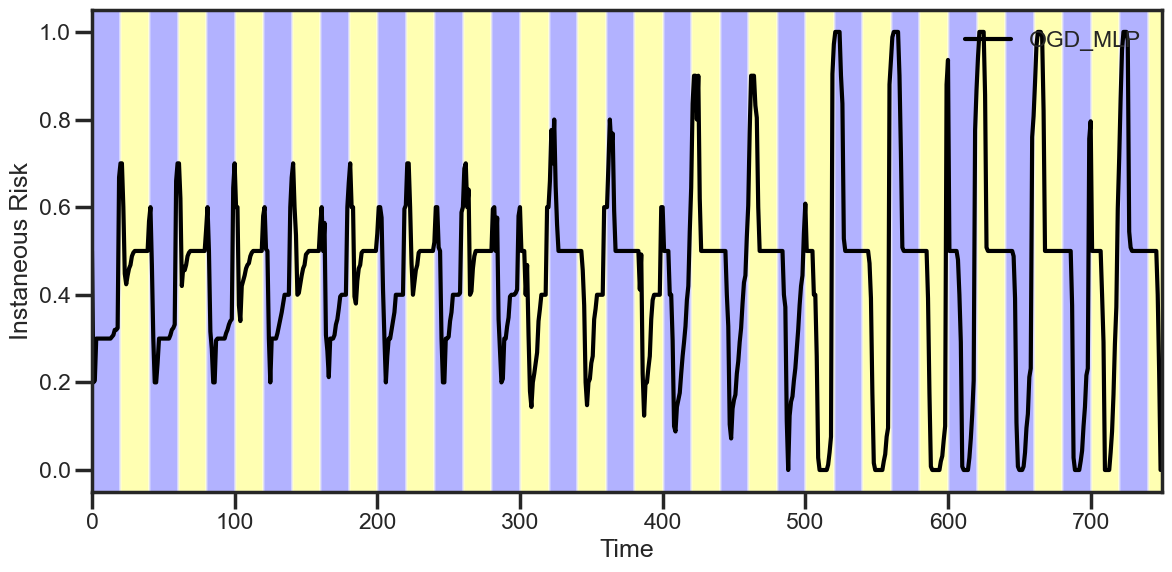

In [225]:
qplot_ins_err(ogd_error,'OGD_MLP',end_time=750)

In [226]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
save_path = './checkpoints/scenario2_m1/'

# Define FTL loop function using 3-layer MLP in PyTorch
def ftl_loop_torch(k):
    # Initialize MLP model and optimizer
    model = MLP_3L(1, 1, 32).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Initialize empty training data
    X_train = torch.empty((0, 1), device=device)
    Y_train = torch.empty((0,), device=device)

    ftl_error = []
    prospective_errors = []

    for t in range(1, T):
        # Obtain new sample from the online sampling function
        x, y = online_sample_from_task_sequence(t, N)
        x = torch.tensor([x], device=device, dtype=torch.float32).view(1, 1)
        y = torch.tensor([y], device=device, dtype=torch.float32).view(1)

        # Obtain test samples for evaluation at time t
        X_test, Y_test = batch_sample_for_future_points(n_test, t, t + 1, N)
        X_test = torch.tensor(X_test, device=device, dtype=torch.float32).view(-1, 1)
        Y_test = torch.tensor(Y_test, device=device, dtype=torch.float32).view(-1)

        # Make predictions and calculate current error
        model.eval()
        with torch.no_grad():
            Y_hat = torch.sign(model(X_test))
        Y_hat = Y_hat.view(-1)
        error = (Y_test != Y_hat).float().mean().item()
        ftl_error.append(error)

        # Only calculate prospective errors for t = k, 2k, 3k, ...
        if t % k == 0:
            X_future, Y_future = batch_sample_for_future_points(n_test, t, T, N)
            future_errors = []

            for future_idx in range(len(X_future)):
                X_future_test = torch.tensor(X_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)
                Y_future_test = torch.tensor(Y_future[future_idx], device=device, dtype=torch.float32).view(-1)

                with torch.no_grad():
                    Y_hat_future = torch.sign(model(X_future_test))
                Y_hat_future = Y_hat_future.view(-1)
                future_error = (Y_future_test != Y_hat_future).float().mean().item()
                future_errors.append(future_error)

            prospective_errors.append(np.mean(future_errors))

        X_train = torch.cat((X_train, x.view(1, 1)), dim=0)
        Y_train = torch.cat((Y_train, y), dim=0)

        # Train the model if enough samples have been collected
        if (Y_train == -1).sum() >= 25 and (Y_train == 1).sum() >= 25:
            model.train()
            optimizer.zero_grad()
            Y_train_binary = (Y_train + 1) / 2  # Convert labels to binary [0, 1] for BCEWithLogitsLoss
            predictions = model(X_train)
            loss = criterion(predictions, Y_train_binary.unsqueeze(1))
            loss.backward()
            optimizer.step()

    return ftl_error, prospective_errors

ftl_file_path = save_path + 'ftl.pkl'
if not os.path.exists(ftl_file_path):
    ftl_error_reps = []
    prospective_error_reps = []

    for _ in range(n_reps):
        ftl_error, prospective_errors = ftl_loop_torch(k)
        
        ftl_error_reps.append(torch.tensor(ftl_error).cpu())
        prospective_error_reps.append(torch.tensor(prospective_errors).cpu())
        
        torch.cuda.empty_cache()

    ftl_error_reps = torch.stack(ftl_error_reps)
    prospective_error_reps = torch.stack(prospective_error_reps)

    ftl_error = ftl_error_reps.mean(dim=0).numpy()
    ftl_prospective_error = prospective_error_reps.mean(dim=0).numpy()
    c_ftl = ftl_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96
    c_ftl_prospective = prospective_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96
    with open(ftl_file_path, 'wb') as f:
        pickle.dump({
            'ftl_error': ftl_error,
            'ftl_prospective_error': ftl_prospective_error,
            'c_ftl': c_ftl,
            'c_ftl_prospective': c_ftl_prospective
        }, f)
        
# Code to read the saved FTL pickle file
with open(ftl_file_path, 'rb') as f:
    ftl_results = pickle.load(f)

# Access the saved data
ftl_error = ftl_results['ftl_error']
ftl_prospective_error = ftl_results['ftl_prospective_error']
c_ftl = ftl_results['c_ftl']
c_ftl_prospective = ftl_results['c_ftl_prospective']

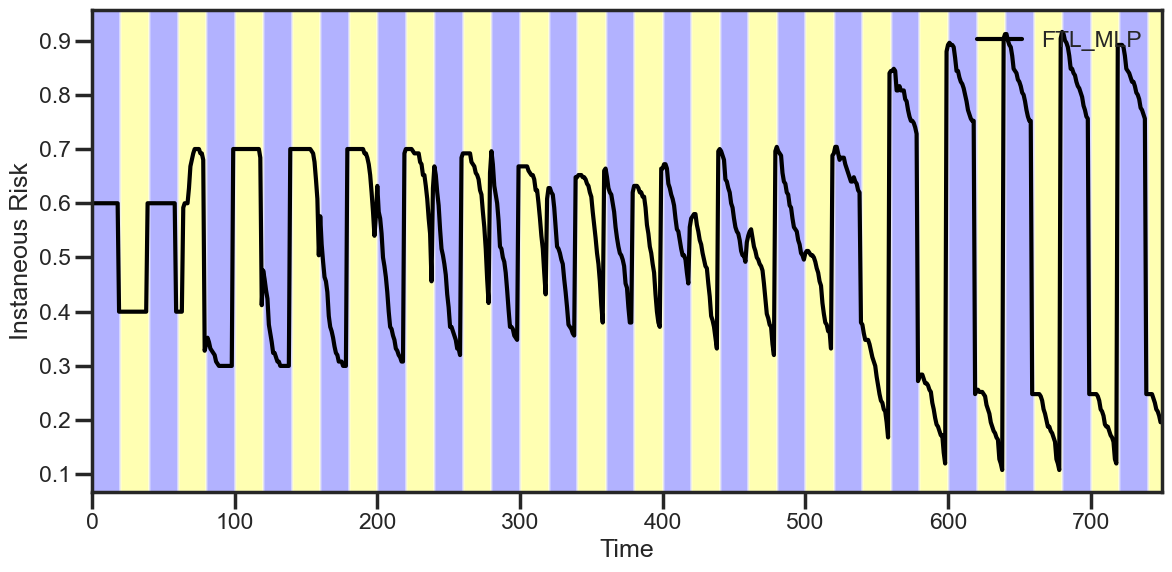

In [227]:
qplot_ins_err(ftl_error,'FTL_MLP',end_time=750)

In [228]:
lr = 0.01

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# BGD Loop with KL Divergence
def bgd_loop_torch():
    # Initialize MLP model
    model = MLP_3L(1, 1, 32).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    bgd_error = []
    prospective_errors = []

    # Fixed variance for simplicity
    sigma = 1.0
    kl_weight = 0.01  # Weight for KL-divergence term to balance regularization

    for t in range(1, T + 1):
        x, y = online_sample_from_task_sequence(t, N)
        x = torch.tensor([[x]], device=device, dtype=torch.float32)
        y = torch.tensor([[y]], device=device, dtype=torch.float32)

        # Forward pass with weight perturbation
        model.train()
        optimizer.zero_grad()

        # Apply random noise to model parameters to simulate weight sampling
        original_state = model.state_dict()
        for param in model.parameters():
            param.data += sigma * torch.randn_like(param)

        # Compute output and classification loss
        output = model(x)
        loss = torch.nn.BCEWithLogitsLoss()(output, (y + 1) / 2)

        # KL-divergence term for regularization (weights close to zero)
        kl_divergence = 0.5 * sum((param ** 2).sum() for param in model.parameters())

        # Total loss: classification loss + KL divergence
        total_loss = loss + kl_weight * kl_divergence
        total_loss.backward()

        # Restore original parameters before optimizer step
        model.load_state_dict(original_state)
        optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            # Test error at time t
            X_test, Y_test = batch_sample_for_future_points(n_test, t, t + 1, N)
            X_test = torch.tensor(X_test[0], device=device, dtype=torch.float32).view(-1, 1)
            Y_test = torch.tensor(Y_test[0], device=device, dtype=torch.float32).view(-1, 1)
            Y_hat = torch.sign(model(X_test))
            error = (Y_test != Y_hat).float().mean().item()
            bgd_error.append(error)

            # Prospective errors every k steps
            if t % k == 0:
                X_future, Y_future = batch_sample_for_future_points(n_test, t, T, N)
                future_errors = []
                for future_idx in range(len(X_future)):
                    X_future_test = torch.tensor(X_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)
                    Y_future_test = torch.tensor(Y_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)
                    Y_hat_future = torch.sign(model(X_future_test))
                    future_error = (Y_future_test != Y_hat_future).float().mean().item()
                    future_errors.append(future_error)
                prospective_errors.append(np.mean(future_errors))

    return bgd_error, prospective_errors

# Save and load results
bgd_file_path = save_path + '/bgd.pkl'
if not os.path.exists(bgd_file_path):
    bgd_error_reps = []
    prospective_error_reps = []

    for _ in range(n_reps):
        bgd_error, prospective_errors = bgd_loop_torch()

        # Move results to CPU to free GPU memory
        bgd_error_reps.append(torch.tensor(bgd_error).cpu())
        prospective_error_reps.append(torch.tensor(prospective_errors).cpu())

        # Clear GPU memory after each repetition
        torch.cuda.empty_cache()

    # Convert lists to tensors
    bgd_error_reps = torch.stack(bgd_error_reps)
    prospective_error_reps = torch.stack(prospective_error_reps)

    # Calculate mean and confidence intervals
    bgd_error = bgd_error_reps.mean(dim=0).numpy()
    bgd_prospective_error = prospective_error_reps.mean(dim=0).numpy()
    c_bgd = bgd_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96
    c_bgd_prospective = prospective_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96

    with open(bgd_file_path, 'wb') as f:
        pickle.dump({
            'bgd_error': bgd_error,
            'bgd_prospective_error': bgd_prospective_error,
            'c_bgd': c_bgd,
            'c_bgd_prospective': c_bgd_prospective
        }, f)

with open(bgd_file_path, 'rb') as f:
    bgd_results = pickle.load(f)

# Access the saved data
bgd_error = bgd_results['bgd_error']
bgd_prospective_error = bgd_results['bgd_prospective_error']
c_bgd = bgd_results['c_bgd']
c_bgd_prospective = bgd_results['c_bgd_prospective']

print("BGD Error:", bgd_error)
print("Prospective Error:", bgd_prospective_error)

BGD Error: [0.6        0.45999998 0.5        ... 0.116      0.08       0.79999995]
Prospective Error: [0.50041051 0.50002666 0.49844705 0.50074499 0.50085333 0.50026857
 0.50150152 0.50009999 0.50099635 0.50014399 0.49691999 0.49982999
 0.50051428 0.50038666 0.50261599 0.50060999 0.50319999 0.49827999
 0.48359999        nan]


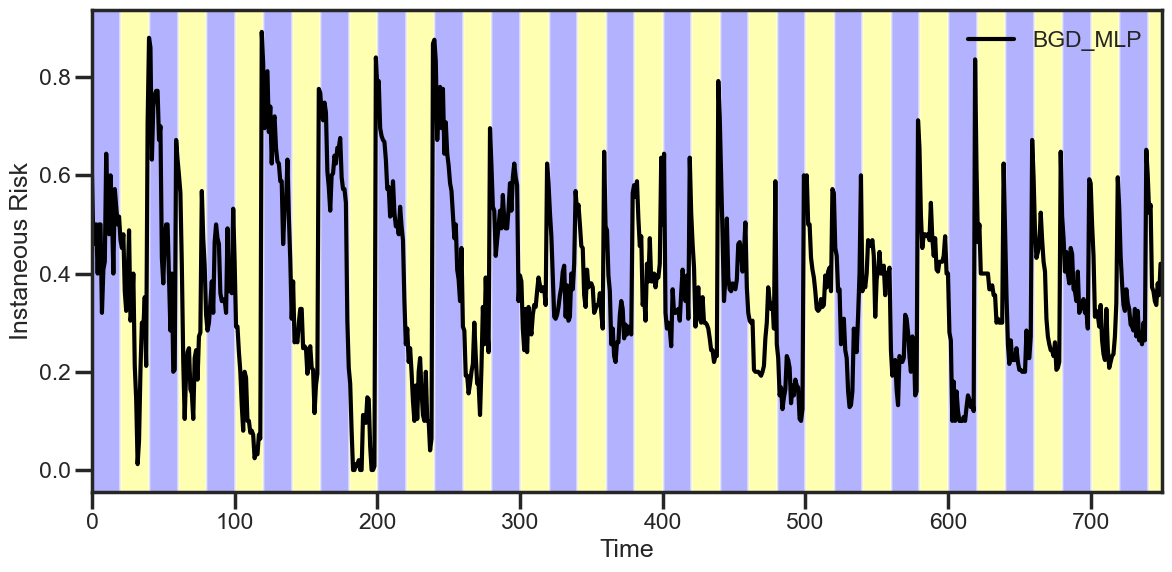

In [229]:
qplot_ins_err(bgd_error,'BGD_MLP',end_time=750)

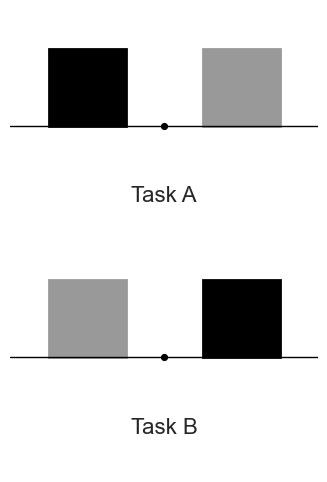

In [230]:
def plot_task(ax, task_name, y_offset, colors, fontsize):
    # Plot rectangles and scatter point
    ax.add_patch(Rectangle((-1.5, y_offset), 1, 1, color=colors[0], alpha=1))  # Left rectangle
    ax.add_patch(Rectangle((0.5, y_offset), 1, 1, color=colors[1], alpha=1))   # Right rectangle
    ax.scatter(0, y_offset, color='black', s=10)  # Center point

    ax.set_xlim([-2, 2])  # Extend the x-limits to create more space between rectangles
    ax.set_ylim([-3, 3])  # Adjust ylim to prevent overlapping of Task A and Task B

    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')

    # for spine in ['left', 'bottom']:
    #     ax.spines[spine].set_linewidth(1)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.axhline(y=y_offset, color='black', linewidth=1)

    ax.set_aspect('equal')

    # Adjust text position based on y_offset
    ax.text(0, y_offset - 1, task_name, fontsize=fontsize, ha='center')

fig, main_ax = plt.subplots(figsize=(8, 6))

# Define colors for Task A and Task B
colors_task_A = ['#000000', '#999999']  # Black on the left, gray on the right
colors_task_B = ['#999999', '#000000']  # Gray on the left, black on the right

# Plot Task A at y_offset = 1.5 and Task B at y_offset = -1.5
plot_task(main_ax, 'Task A', 1.5, colors_task_A, 16)  # Task A with y_offset=1.5
plot_task(main_ax, 'Task B', -1.5, colors_task_B, 16)  # Task B with y_offset=-1.5

plt.show()

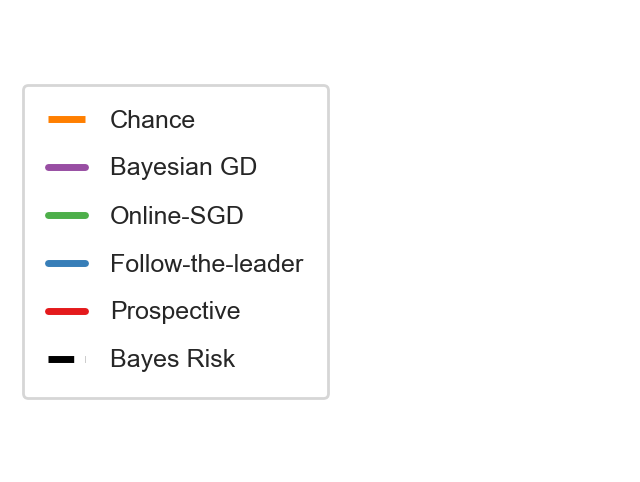

In [231]:
def plot_legend(ax, fontsize):
    colors = {'Chance': '#ff7f00', 'Bayesian GD': '#984ea3', 'Online-SGD': '#4daf4a', 
            'Follow-the-leader': '#377eb8', 'Prospective': '#e41a1c', 'Bayes Risk': 'black'}

    linestyles = {'Chance': '-.', 'Bayesian GD': '-', 'Online-SGD': '-', 
                'Follow-the-leader': '-', 'Prospective': '-', 'Bayes Risk': '--'}

    for label, color in colors.items():
        ax.plot([], [], color=color, linestyle=linestyles[label], label=label, linewidth=5)

    legend = ax.legend(frameon=True, loc='center left', ncol=1, fontsize=fontsize, handlelength=1.5, handletextpad=1, borderpad=1, labelspacing=1)

    # legend.get_frame().set_edgecolor('grey')  
    legend.get_frame().set_linewidth(2)  

    ax.axis('off')

fig, main_ax = plt.subplots(figsize=(8, 6))
plot_legend(main_ax, 18)

In [232]:
def make_plot1(info, title, figname, ax, fontsize, size=50, plot_index=None, subsample=None,
              outside_legend=False, minimal=False, discount=False):
    ax.set_ylim([-0.05, 1])
    ax.set_title(title, fontsize=fontsize)

    cols = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3',
            '#ff7f00', '#ffff33', '#a65628']

    methods = []
    methods_legend = []
    for m in info:
        methods.append(m)
        # print(m)
        if m == 'ERM':
            methods_legend.append('Follow-the-leader')
        else:
            methods_legend.append(m)

    ax.set_ylabel("Prospective Risk", fontsize=fontsize)
    ax.set_xlabel("Time (t)", fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)


    if plot_index is not None:
        methods = [methods[i] for i in plot_index]

    if subsample is not None:
        for m, s in subsample:
            info[methods[m]]= info[methods[m]][:,::s]
            
    for i, m in enumerate(methods):
        ax.plot(info[m][2], info[m][0], c=cols[i])

    # plot chance risk
    if "syn" in figname:
        ax.axhline(y=0.5, color='#ff7f00', linestyle='--')
    elif "mnist" or "cifar" in figname:
        ax.axhline(y=0.742, color='#ff7f00', linestyle='--')

    for i, m in enumerate(methods):
        ax.scatter(info[m][2], info[m][0], c=cols[i], s=size)
        std = 2 * info[m][1] / np.sqrt(5)
        mean = info[m][0]
        ax.fill_between(info[m][2], mean-std, mean+std,
                         alpha=0.3, color=cols[i])

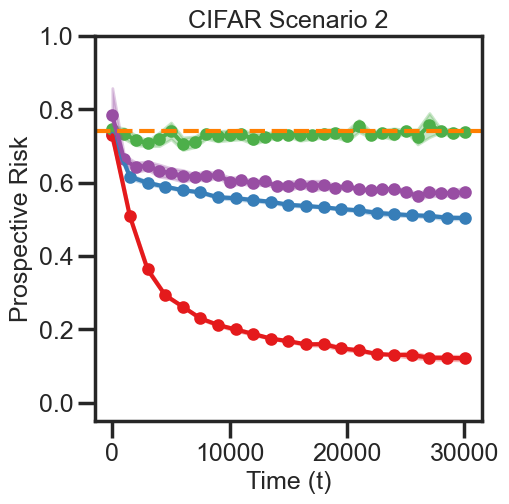

In [233]:
def mnist_scenario2(ax, fontsize):
    info = np.load("./metrics/mnist_scenario2.pkl", allow_pickle=True)
    make_plot1(info, "MNIST Scenario 2", figname="mnist_scenario2", ax=ax, fontsize=fontsize, minimal=True)

def cifar_scenario2(ax, fontsize):
    info = np.load("./metrics/cifar_scenario2.pkl", allow_pickle=True)
    make_plot1(info, "CIFAR Scenario 2", figname="cifar_scenario2",ax=ax, fontsize=fontsize,
                plot_index=[0, 1, 2, 3], subsample=[(2, 2), (3, 2)], minimal=True)

fig, main_ax = plt.subplots(figsize=(5, 5))
cifar_scenario2(main_ax, 18)

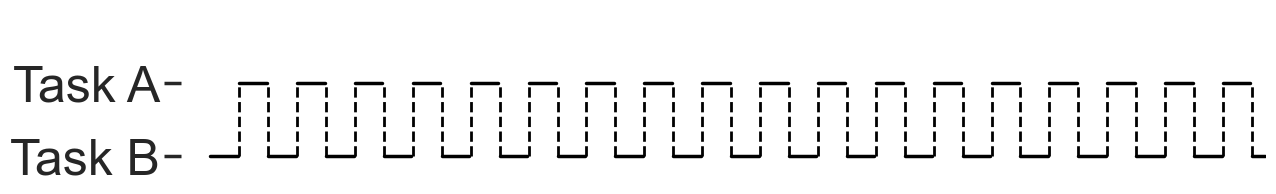

In [234]:
def plot_task_excuting(start_time, end_time, N, fontsize, ax):
    times = np.arange(start_time,end_time,1)
    task1_y = np.zeros_like(times)
    task2_y = np.ones_like(times)

    # Plot solid lines for tasks
    for i in range(start_time+N, end_time, 2*N):
        ax.plot(times[i:i+N], task1_y[i:i+N], color='black', lw=2.5, label='Task 1' if i == 0 else "")
        ax.plot(times[i+N:i+2*N], task2_y[i+N:i+2*N], color='black', lw=2.5, label='Task 2' if i == 0 else "")

    # Plot dashed lines to indicate task switches
    for i in range(start_time+2*N, end_time, N):
        ax.plot([i, i], [0, 1], color='black', linestyle='dashed', lw=2)

    # Customize the plot
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Task B', 'Task A'], fontsize=fontsize)
    ax.set_xticks([])
    ax.set_xlim([start_time, end_time])
    ax.set_ylim([-0.1, 2])
    ax.set_frame_on(False) 
    ax.grid(False)
    
    sns.set_style("white")
    sns.set_style("ticks")
    sns.set_palette('pastel')

fig, main_ax = plt.subplots(figsize=(14, 2))
plot_task_excuting(0, 750, 20, 36, main_ax)

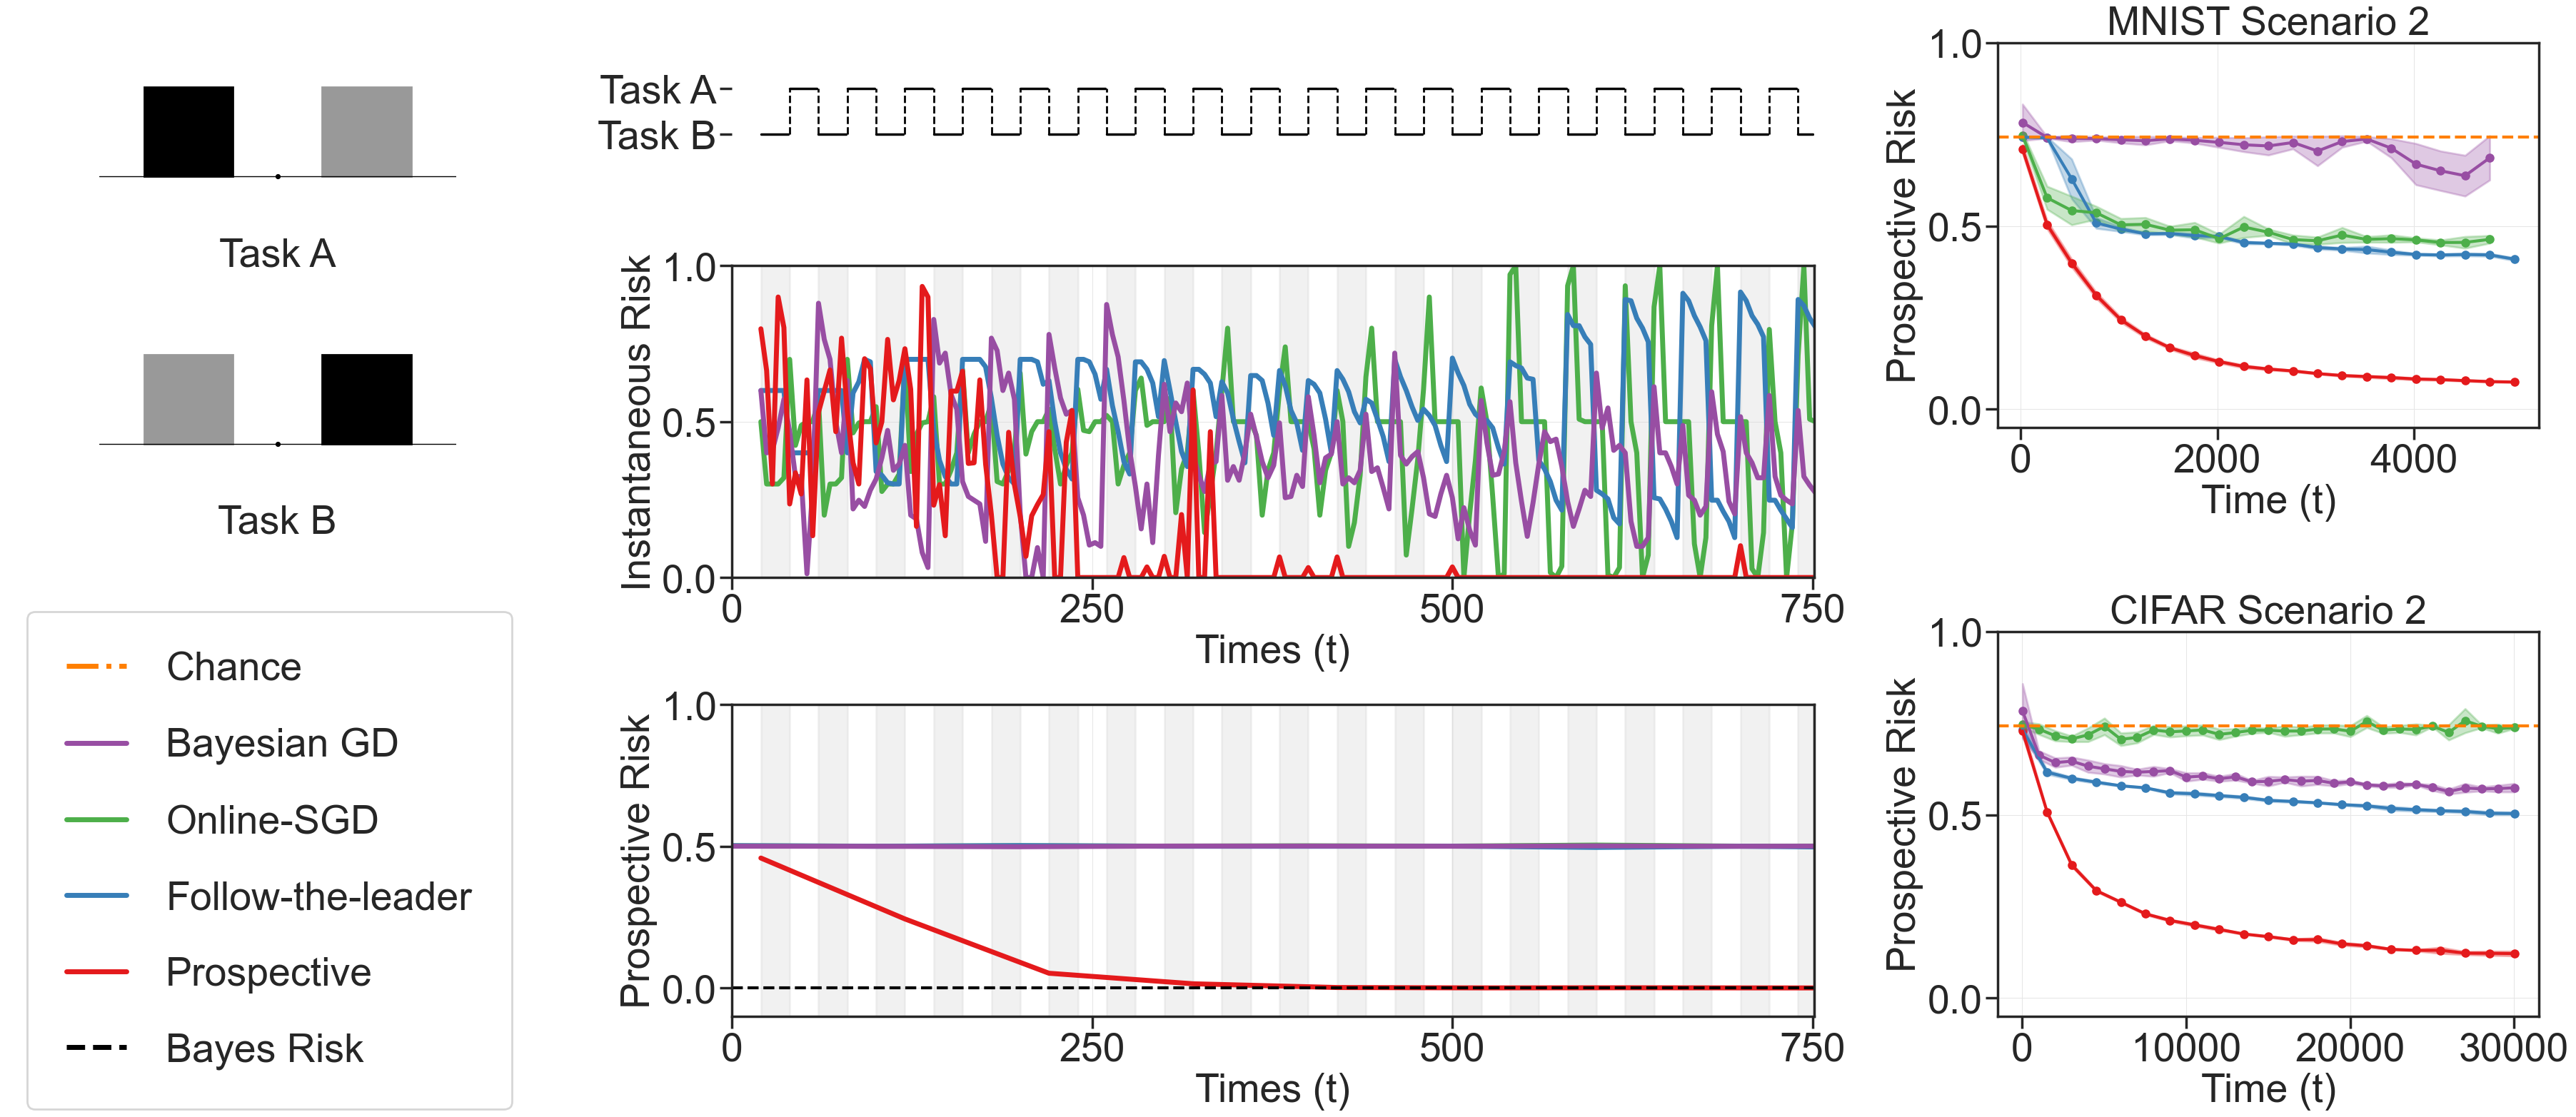

In [235]:
import matplotlib.gridspec as gridspec
colors = {'OGD': '#4daf4a', 'FTL': '#377eb8', 'Prospective MLP': '#e41a1c','BGD':'#984ea3'}
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(context='poster',
        style='ticks',
        font_scale=.75,
        rc={'axes.grid': True,
            'grid.color': '.9',
            'grid.linewidth': 0.75})

start_time = 0
end_time = 751
stepsz = 4
N = 20
fontsize=40

fig = plt.figure(figsize=(36, 16))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 2, 1], height_ratios=[2, 6.5, 6.5])

# First column
axes = {}
axes['left1'] = fig.add_subplot(gs[0:2, 0])  # 'left1' spans rows 0 and 1 in column 0
axes['left2'] = fig.add_subplot(gs[2, 0])    # 'left2' in row 2, column 0

# Second column
axes['right1'] = fig.add_subplot(gs[0, 1])   # 'right1' in row 0, column 1
axes['right2'] = fig.add_subplot(gs[1, 1])   # 'right2' in row 1, column 1
axes['right3'] = fig.add_subplot(gs[2, 1])   # 'right3' in row 2, column 1

# Third column: Nested GridSpec to split the space equally between 'right4' and 'right5'
gs_right_col = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[:, 2])

axes['right4'] = fig.add_subplot(gs_right_col[0])  # Upper half of third column
axes['right5'] = fig.add_subplot(gs_right_col[1])  # Lower half of third column

plt.subplots_adjust(wspace=0.1, hspace=0.15)

x, y = np.mgrid[-2:2:.1, -2:2:.1]
ax1 = axes['left1']
# Define colors for Task A and Task B
colors_task_A = ['#000000', '#999999']  # Black on the left, gray on the right
colors_task_B = ['#999999', '#000000']  # Gray on the left, black on the right

# Plot Task A at y_offset = 1.5 and Task B at y_offset = -1.5
plot_task(ax1, 'Task A', 1.5, colors_task_A, fontsize)  # Task A with y_offset=1.5
plot_task(ax1, 'Task B', -1.5, colors_task_B, fontsize)  # Task B with y_offset=-1.5

plot_legend(axes['left2'], fontsize)
plot_task_excuting(start_time, end_time, N, fontsize, axes['right1'])

ax = axes['right2']
ax.plot(pl_times[start_time:end_time:stepsz], ogd_error[start_time:end_time:stepsz],lw=5,c=colors['OGD'], label='OGD')
ax.plot(pl_times[start_time:end_time:stepsz], ftl_error[start_time:end_time:stepsz], lw=5,c=colors['FTL'], label='FTL')
ax.plot(pl_times[start_time:end_time:stepsz], bgd_error[start_time:end_time:stepsz], lw=5,c=colors['BGD'], label='BGD')
ax.plot(pl_times[::stepsz], pl_inst_errors[::stepsz], c=colors['Prospective MLP'], lw=5,label='Prospective MLP')
ax.set_xlabel("Times (t)", fontsize=fontsize)
ax.set_ylabel("Instantaneous Risk", fontsize=fontsize)

ax.set_xlim(start_time, end_time)
ax.set_xticks([0, 250, 500,750])
ax.set_xticklabels(['0', '250','500','750'], fontsize=fontsize)
ax.set_ylim([-0., 1])
ax.tick_params(axis='y', labelsize=fontsize)

ax = axes['right3']
ax.plot(np.arange(start_time,end_time+k,k), ogd_prospective_error[int(start_time/k):int(end_time/k)+2], lw=5, c=colors['OGD'], label='OGD')
ax.plot(np.arange(start_time,end_time+k,k), ftl_prospective_error[int(start_time/k):int(end_time/k)+2], lw=5, c=colors['FTL'], label='Follow-the-leader')
ax.plot(np.arange(start_time,end_time+k,k), bgd_prospective_error[int(start_time/k):int(end_time/k)+2], lw=5, c=colors['BGD'], label='Bayesian GD')
ax.plot(pl_plrisk_times[:], pl_plrisk[:], lw=5,c=colors['Prospective MLP'], label='Prospective')
ax.axhline(y=0, color='black', linestyle='--',label='Bayes Risk')
ax.set_xlabel("Times (t)", fontsize=fontsize)
ax.set_ylabel("Prospective Risk", fontsize=fontsize)
# ax.legend(loc='upper right')
ax.set_xlim(start_time, end_time)

ax.set_xticks([0, 250, 500,750])
ax.set_xticklabels(['0', '250','500','750'], fontsize=fontsize)
ax.set_ylim([-0.1, 1])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis='y', labelsize=fontsize)

# fig.suptitle('Synthetic Scenario 2', fontsize=fontsize)
for i in range(start_time, end_time, N*2):
    task_b_start = i + N  # Task B starts after Task A
    task_b_end = i + 2 * N  # Task B ends after its 20-second interval

    # Add shading for Task B execution intervals
    axes['right2'].fill_betweenx([-0.1, 1.1], task_b_start, task_b_end, color='lightgray', alpha=0.3)
    axes['right3'].fill_betweenx([-0.1, 1], task_b_start, task_b_end, color='lightgray', alpha=0.3)
    
mnist_scenario2(axes['right4'],fontsize)
cifar_scenario2(axes['right5'],fontsize)

plt.plot()
plt.tight_layout()
plt.savefig("./figures/overall_scenario2_mlp.pdf", format="pdf", bbox_inches="tight")